# Stoichiometry Screening: Getting the Ratios Right

You've mastered chemical filters and compositional screening - now it's time to tackle a more focused challenge: **finding the right atomic ratios**. Once you know which elements to combine, how do you determine the optimal stoichiometry?

This tutorial will teach you to systematically explore stoichiometric spaces and identify chemically viable atomic ratios using SMACT.

## What You'll Learn

1. **Distinguish compositional from stoichiometric screening**
2. **Generate systematic stoichiometric spaces** for element combinations
3. **Apply chemical validation rules** to atomic ratios
4. **Screen specific structure types** (binary, perovskite, quaternary)
5. **Use ICSD occurrence data** to guide predictions
6. **Visualise stoichiometric validity** with interactive plots

## The Foundation: Previous Learning

This builds directly on your previous knowledge:
- **Chemical Filters**: Provide the validation rules we'll apply
- **Compositional Screening**: Identified promising element combinations
- **Stoichiometry Screening**: Now finds optimal atomic ratios

Let's begin exploring the systematic world of atomic ratios!

In [18]:
# Import Libraries

import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Materials science libraries
from pymatgen.core import Composition

# SMACT for stoichiometric screening
import smact
from smact import Element, Species
from smact.screening import smact_validity
from smact.utils.oxidation import ICSD24OxStatesFilter

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("Ready to begin stoichiometry screening")

Libraries imported successfully!
Ready to begin stoichiometry screening


## Understanding the Difference: Compositional vs Stoichiometric Screening

Let's clarify this important distinction with concrete examples:

**Compositional Screening** asks: *"Should I combine Cu, Ti, and O?"*
- Explores which elements to use together
- Maps entire chemical systems like Cu-Ti-O
- Answers: "Yes, Cu-Ti-O is a viable system"

**Stoichiometry Screening** asks: *"Given Cu, Ti, and O, should I make CuTiO₃, Cu₂TiO₄, or CuTi₂O₅?"*
- Explores different atomic ratios within known systems
- Applies chemical rules to specific stoichiometries
- Answers: "CuTiO₃ is chemically valid, but Cu₅TiO₁₃ is not"

Both are essential for comprehensive materials discovery!

## Step 1: Binary Stoichiometry Screening

In [19]:

def screen_binary_stoichiometries(element_A, element_B, max_stoich=5):
    """
    Screen all possible stoichiometries for a binary system A_x B_y.
    
    Args:
        element_A, element_B (str): Element symbols
        max_stoich (int): Maximum stoichiometric coefficient
        
    Returns:
        pandas.DataFrame: Results with compositions and validity
    """
    results = []
    
    # Test all combinations of stoichiometric coefficients
    for x in range(1, max_stoich + 1):
        for y in range(1, max_stoich + 1):
            # Create composition
            comp = Composition({element_A: x, element_B: y}).reduced_composition
            
            # Test chemical validity
            is_valid = smact_validity(comp)
            
            results.append({
                'stoichiometry': f"{element_A}{x}{element_B}{y}",
                'composition': comp,
                'formula': comp.reduced_formula,
                'valid': is_valid,
                'coeff_A': x,
                'coeff_B': y
            })
    
    # Create DataFrame and remove duplicates
    df = pd.DataFrame(results)
    df = df.drop_duplicates('formula').reset_index(drop=True)
    
    return df

# Example: Screen sodium chloride stoichiometries
print("Screening Na-Cl binary stoichiometries...")
nacl_results = screen_binary_stoichiometries("Na", "Cl", max_stoich=4)

print(f"\nFound {len(nacl_results)} unique stoichiometries:")
print(nacl_results[['formula', 'valid']].head(8))

# Count valid vs invalid
valid_count = nacl_results['valid'].sum()
total_count = len(nacl_results)
print(f"\nValid stoichiometries: {valid_count}/{total_count} ({valid_count/total_count*100:.1f}%)")

Screening Na-Cl binary stoichiometries...

Found 11 unique stoichiometries:
  formula  valid
0    NaCl   True
1   NaCl2  False
2   NaCl3  False
3   NaCl4  False
4   Na2Cl  False
5  Na2Cl3  False
6   Na3Cl  False
7  Na3Cl2  False

Valid stoichiometries: 1/11 (9.1%)


## Step 2: Visualise Binary Stoichiometric Space

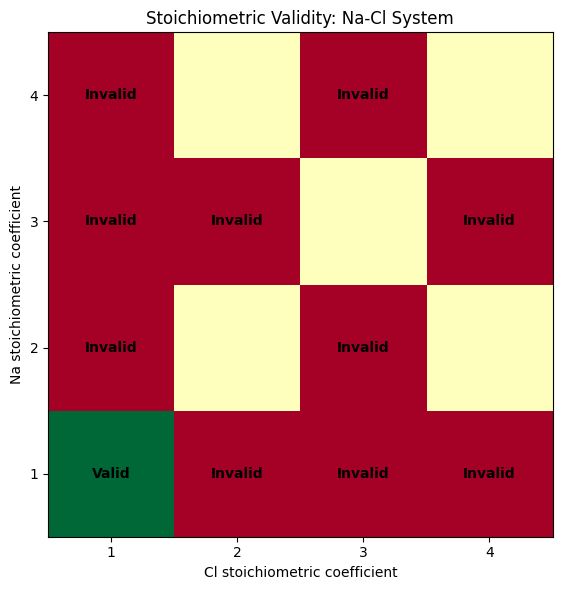


Grid interpretation:
- Green (Valid): Stoichiometry passes SMACT chemical rules
- Red (Invalid): Stoichiometry violates charge neutrality or electronegativity rules
- Only NaCl (1:1 ratio) is chemically valid for this system


In [20]:

def plot_stoichiometric_grid(df, element_A, element_B, max_display=5):
    """
    Create a grid visualisation of binary stoichiometric validity.
    
    Args:
        df (DataFrame): Results from binary screening
        element_A, element_B (str): Element symbols
        max_display (int): Maximum coefficient to display
    """
    # Create grid matrix
    grid = np.zeros((max_display, max_display))
    
    for _, row in df.iterrows():
        if row['coeff_A'] <= max_display and row['coeff_B'] <= max_display:
            x_idx = row['coeff_A'] - 1
            y_idx = row['coeff_B'] - 1
            grid[x_idx, y_idx] = 1 if row['valid'] else -1
    
    # Create plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot grid with colour coding
    im = ax.imshow(grid, cmap='RdYlGn', aspect='equal', origin='lower', 
                   extent=[0.5, max_display+0.5, 0.5, max_display+0.5])
    
    # Add text annotations
    for i in range(max_display):
        for j in range(max_display):
            value = grid[i, j]
            if value == 1:
                text = "Valid"
                colour = "black"
            elif value == -1:
                text = "Invalid"
                colour = "black"
            else:
                text = ""
                colour = "grey"
            
            ax.text(j+1, i+1, text, ha='center', va='center', 
                   color=colour, fontsize=10, weight='bold')
    
    # Formatting
    ax.set_xlabel(f"{element_B} stoichiometric coefficient")
    ax.set_ylabel(f"{element_A} stoichiometric coefficient")
    ax.set_title(f"Stoichiometric Validity: {element_A}-{element_B} System")
    
    # Set ticks
    ax.set_xticks(range(1, max_display+1))
    ax.set_yticks(range(1, max_display+1))
    
    plt.tight_layout()
    plt.show()

# Plot the Na-Cl results
plot_stoichiometric_grid(nacl_results, "Na", "Cl", max_display=4)

print("\nGrid interpretation:")
print("- Green (Valid): Stoichiometry passes SMACT chemical rules")
print("- Red (Invalid): Stoichiometry violates charge neutrality or electronegativity rules")
print("- Only NaCl (1:1 ratio) is chemically valid for this system")

## Step 3: Ternary Perovskite Screening (ABX₃)

In [21]:

def screen_perovskite_stoichiometries(A_elements, B_elements, X_elements):
    """
    Screen ABX₃ perovskite stoichiometries systematically.
    
    Args:
        A_elements, B_elements, X_elements (list): Element lists for each site
        
    Returns:
        pandas.DataFrame: Perovskite screening results
    """
    results = []
    
    # Test all combinations of A, B, X elements
    for A in A_elements:
        for B in B_elements:
            for X in X_elements:
                # Create ABX₃ composition
                comp = Composition({A: 1, B: 1, X: 3})
                
                # Test validity
                is_valid = smact_validity(comp)
                
                results.append({
                    'A_element': A,
                    'B_element': B, 
                    'X_element': X,
                    'formula': comp.reduced_formula,
                    'composition': comp,
                    'valid': is_valid
                })
    
    return pd.DataFrame(results)

# Define element sets for perovskite screening
A_site = ["Ca", "Sr", "Ba"]  # Large cations
B_site = ["Ti", "Zr", "Sn"]  # Smaller cations
X_site = ["O"]               # Anions

print("Screening ABX₃ perovskite stoichiometries...")
perovskite_results = screen_perovskite_stoichiometries(A_site, B_site, X_site)

print(f"\nPerovskite screening results:")
print(perovskite_results[['formula', 'valid']])

# Analyse results
valid_perovskites = perovskite_results[perovskite_results['valid']]
print(f"\nValid perovskite compositions: {len(valid_perovskites)}/{len(perovskite_results)}")

if len(valid_perovskites) > 0:
    print("\nChemically valid perovskites found:")
    for _, row in valid_perovskites.iterrows():
        print(f"  {row['formula']} ({row['A_element']}-{row['B_element']}-{row['X_element']})")

Screening ABX₃ perovskite stoichiometries...

Perovskite screening results:
  formula  valid
0  CaTiO3   True
1  CaZrO3   True
2  CaSnO3   True
3  SrTiO3   True
4  SrZrO3   True
5  SrSnO3   True
6  BaTiO3   True
7  BaZrO3   True
8  BaSnO3   True

Valid perovskite compositions: 9/9

Chemically valid perovskites found:
  CaTiO3 (Ca-Ti-O)
  CaZrO3 (Ca-Zr-O)
  CaSnO3 (Ca-Sn-O)
  SrTiO3 (Sr-Ti-O)
  SrZrO3 (Sr-Zr-O)
  SrSnO3 (Sr-Sn-O)
  BaTiO3 (Ba-Ti-O)
  BaZrO3 (Ba-Zr-O)
  BaSnO3 (Ba-Sn-O)


## Step 4: Advanced Stoichiometric Analysis with ICSD Data

Exploring ICSD oxidation state occurrence data...

Most common oxidation states in experimental structures:
  species  results_count
0     O2-         116910
1      H+          34232
2    Si4+          18248
3     Na+          17539
4    Ca2+          16605
5    Al3+          15020
6    Ba2+          14917
7     N3-          13983
8      K+          13748
9     S2-          13417

Oxidation state analysis for valid perovskites:
  CaTiO3: Ca: [2]; Ti: [2, 3, 4]; O: [-2, -1]
  CaZrO3: Ca: [2]; Zr: [1, 2, 3]; O: [-2, -1]
  CaSnO3: Ca: [2]; Sn: [-4, -2, -1]; O: [-2, -1]
  SrTiO3: Sr: [2, 4]; Ti: [2, 3, 4]; O: [-2, -1]
  SrZrO3: Sr: [2, 4]; Zr: [1, 2, 3]; O: [-2, -1]
  SrSnO3: Sr: [2, 4]; Sn: [-4, -2, -1]; O: [-2, -1]
  BaTiO3: Ba: [2]; Ti: [2, 3, 4]; O: [-2, -1]
  BaZrO3: Ba: [2]; Zr: [1, 2, 3]; O: [-2, -1]
  BaSnO3: Ba: [2]; Sn: [-4, -2, -1]; O: [-2, -1]


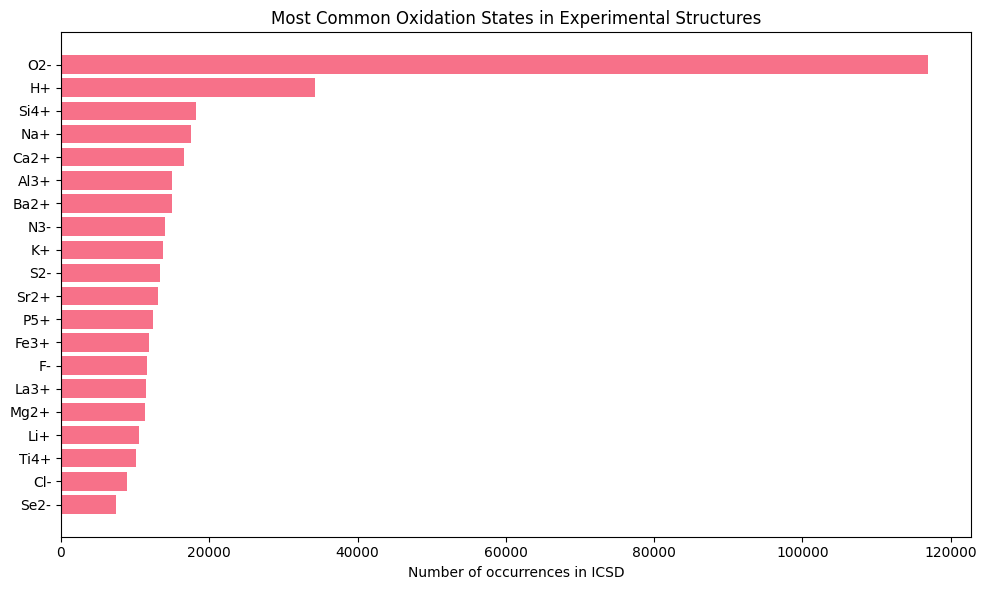


Key insight: O²⁻ is by far the most common oxidation state,
appearing in over 116,000 structures. This validates our focus on oxides.


In [22]:

print("Exploring ICSD oxidation state occurrence data...")

# Load ICSD oxidation state filter
icsd_filter = ICSD24OxStatesFilter()
occurrence_data = icsd_filter.get_species_occurrences_df(sort_by_occurrences=True)

print("\nMost common oxidation states in experimental structures:")
print(occurrence_data.head(10)[['species', 'results_count']])

# Analyse our perovskite results in context of ICSD data
def analyse_oxidation_states(formula):
    """
    Analyse the likely oxidation states for a given formula.
    This is a simplified analysis - in practice, you'd want to
    systematically test all valid oxidation state combinations.
    """
    comp = Composition(formula)
    
    analysis = []
    for element, amount in comp.items():
        element_obj = Element(element.symbol)
        common_states = element_obj.oxidation_states[:3]  # Most common states
        analysis.append(f"{element.symbol}: {common_states}")
    
    return "; ".join(analysis)

print("\nOxidation state analysis for valid perovskites:")
for _, row in valid_perovskites.iterrows():
    ox_analysis = analyse_oxidation_states(row['formula'])
    print(f"  {row['formula']}: {ox_analysis}")

# Plot ICSD occurrence distribution
plt.figure(figsize=(10, 6))
top_20 = occurrence_data.head(20)
plt.barh(range(len(top_20)), top_20['results_count'])
plt.yticks(range(len(top_20)), top_20['species'])
plt.xlabel('Number of occurrences in ICSD')
plt.title('Most Common Oxidation States in Experimental Structures')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nKey insight: O²⁻ is by far the most common oxidation state,")
print("appearing in over 116,000 structures. This validates our focus on oxides.")

## Step 5: Comprehensive Stoichiometric Survey

In [23]:

def comprehensive_stoichiometric_survey(elements, max_stoich=3):
    """
    Perform a comprehensive survey of all possible stoichiometries
    for a given set of elements.
    
    Args:
        elements (list): Elements to survey
        max_stoich (int): Maximum stoichiometric coefficient
        
    Returns:
        pandas.DataFrame: Comprehensive results
    """
    results = []
    
    # Generate all possible stoichiometric combinations
    coefficients = range(1, max_stoich + 1)
    
    for stoich_combo in itertools.product(coefficients, repeat=len(elements)):
        # Create composition
        comp_dict = dict(zip(elements, stoich_combo))
        comp = Composition(comp_dict).reduced_composition
        
        # Test validity
        is_valid = smact_validity(comp)
        
        results.append({
            'elements': '-'.join(elements),
            'stoichiometry': ':'.join(map(str, stoich_combo)),
            'composition': comp,
            'formula': comp.reduced_formula,
            'valid': is_valid,
            'num_atoms': comp.num_atoms,
            'num_elements': len(comp.elements)
        })
    
    # Remove duplicates and sort
    df = pd.DataFrame(results)
    df = df.drop_duplicates('formula').reset_index(drop=True)
    df = df.sort_values(['valid', 'num_atoms'], ascending=[False, True])
    
    return df

# Example: Survey Cu-Ti-O system
print("Performing comprehensive stoichiometric survey of Cu-Ti-O system...")
cto_survey = comprehensive_stoichiometric_survey(["Cu", "Ti", "O"], max_stoich=3)

print(f"\nSurvey results summary:")
print(f"Total unique compositions: {len(cto_survey)}")
print(f"Valid compositions: {cto_survey['valid'].sum()}")
print(f"Success rate: {cto_survey['valid'].mean()*100:.1f}%")

# Show valid compositions
valid_cto = cto_survey[cto_survey['valid']]
print(f"\nValid Cu-Ti-O stoichiometries (ordered by complexity):")
for i, (_, row) in enumerate(valid_cto.head(8).iterrows(), 1):
    print(f"  {i:2d}. {row['formula']} ({row['num_atoms']} atoms)")

if len(valid_cto) > 8:
    print(f"     ... and {len(valid_cto)-8} more valid compositions")

Performing comprehensive stoichiometric survey of Cu-Ti-O system...

Survey results summary:
Total unique compositions: 25
Valid compositions: 7
Success rate: 28.0%

Valid Cu-Ti-O stoichiometries (ordered by complexity):
   1. TiCuO2 (4.0 atoms)
   2. TiCuO3 (5.0 atoms)
   3. Ti(CuO)2 (5.0 atoms)
   4. Ti2CuO3 (6.0 atoms)
   5. TiCu2O3 (6.0 atoms)
   6. Ti2Cu2O3 (7.0 atoms)
   7. Ti(CuO)3 (7.0 atoms)


## Step 6: Interactive Ternary Visualisation


In [24]:

def create_ternary_stoichiometry_plot(df, elements):
    """
    Create an interactive ternary plot showing stoichiometric validity.
    
    Args:
        df (DataFrame): Survey results
        elements (list): Three elements for ternary plot
    """
    def composition_to_fractions(comp, element_list):
        """Convert composition to fractional coordinates for ternary plotting."""
        amounts = [comp[el] for el in element_list]
        total = sum(amounts)
        return [amt/total for amt in amounts] if total > 0 else [0, 0, 0]
    
    # Convert compositions to ternary coordinates
    fractions = np.array([composition_to_fractions(row['composition'], elements) 
                         for _, row in df.iterrows()])
    
    # Create figure
    fig = go.Figure()
    
    # Plot valid compositions
    valid_mask = df['valid'].values
    if valid_mask.any():
        valid_fractions = fractions[valid_mask]
        valid_formulas = df[valid_mask]['formula'].values
        
        fig.add_trace(go.Scatterternary(
            a=valid_fractions[:, 0],
            b=valid_fractions[:, 1], 
            c=valid_fractions[:, 2],
            mode="markers",
            marker=dict(
                size=10, 
                color="green", 
                symbol="circle",
                opacity=0.9,
                line=dict(width=1.5, color="darkgreen")
            ),
            text=valid_formulas,
            name="Valid Stoichiometries",
            hovertemplate="<b>%{text}</b><br>" +
                         f"{elements[0]}: %{{a:.3f}}<br>" +
                         f"{elements[1]}: %{{b:.3f}}<br>" +
                         f"{elements[2]}: %{{c:.3f}}<extra></extra>"
        ))
    
    # Plot invalid compositions
    invalid_mask = ~valid_mask
    if invalid_mask.any():
        invalid_fractions = fractions[invalid_mask]
        invalid_formulas = df[invalid_mask]['formula'].values
        
        fig.add_trace(go.Scatterternary(
            a=invalid_fractions[:, 0],
            b=invalid_fractions[:, 1],
            c=invalid_fractions[:, 2],
            mode="markers",
            marker=dict(
                size=8, 
                color="red", 
                symbol="x",
                opacity=0.7,
                line=dict(width=1, color="darkred")
            ),
            text=invalid_formulas,
            name="Invalid Stoichiometries",
            hovertemplate="<b>%{text}</b><br>" +
                         f"{elements[0]}: %{{a:.3f}}<br>" +
                         f"{elements[1]}: %{{b:.3f}}<br>" +
                         f"{elements[2]}: %{{c:.3f}}<extra></extra>"
        ))
    
    # Enhanced styling
    axis_style = dict(
        title=dict(font=dict(size=16, color="black")),
        linewidth=2,
        linecolor="black",
        gridcolor="rgba(128, 128, 128, 0.4)",
        showticklabels=True,
        tickvals=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        tickfont=dict(size=12)
    )
    
    # Update layout
    fig.update_layout(
        title=dict(
            text=f"Stoichiometric Validity in {'-'.join(elements)} System",
            font=dict(size=18, color="black"),
            x=0.5
        ),
        font=dict(size=12, family="Arial"),
        width=1000,
        height=600,
        ternary=dict(
            bgcolor="rgba(250, 250, 250, 0.8)",
            aaxis=dict(axis_style, title=f"{elements[0]}"),
            baxis=dict(axis_style, title=f"{elements[1]}"),
            caxis=dict(axis_style, title=f"{elements[2]}")
        ),
        showlegend=True,
        legend=dict(
            x=0.02, y=0.98, 
            bgcolor="rgba(255,255,255,0.9)",
            bordercolor="gray",
            borderwidth=1
        ),
        paper_bgcolor="white"
    )
    
    fig.show()

# Create ternary plot for Cu-Ti-O system
create_ternary_stoichiometry_plot(cto_survey, ["Cu", "Ti", "O"])

print("\nTernary plot interpretation:")
print("- Green circles: Chemically valid stoichiometries")
print("- Red X marks: Invalid stoichiometries (violate chemical rules)")
print("- Position shows relative atomic fractions in ternary space")
print("- Hover over points to see exact compositions and formulas")


Ternary plot interpretation:
- Green circles: Chemically valid stoichiometries
- Red X marks: Invalid stoichiometries (violate chemical rules)
- Position shows relative atomic fractions in ternary space
- Hover over points to see exact compositions and formulas


## Summary: Mastering Stoichiometric Screening

In [26]:

print("Congratulations! You have now completed the stoichiometry screening tutorial!")
print("=" * 65)

print("\nKEY CONCEPTS MASTERED:")
print("- Systematic generation of stoichiometric combinations")
print("- Chemical validation of atomic ratios")
print("- Binary, ternary, and multi-component screening")
print("- ICSD occurrence data for evidence-based screening")
print("- Interactive visualisation of stoichiometric spaces")

print("\nTHE SCREENING WORKFLOW:")
print("1. Define element combinations of interest")
print("2. Generate systematic stoichiometric variations")
print("3. Apply SMACT chemical validity rules")
print("4. Analyse results using occurrence statistics")
print("5. Visualise valid stoichiometric spaces")
print("6. Prioritise compositions for synthesis/computation")

if 'cto_survey' in locals():
    valid_count = cto_survey['valid'].sum()
    total_count = len(cto_survey)
    print(f"\nYOUR ANALYSIS RESULTS:")
    print(f"- Screened {total_count} stoichiometric combinations")
    print(f"- Found {valid_count} chemically valid compositions")
    print(f"- Achieved {valid_count/total_count*100:.1f}% success rate")

print("\nNEXT STEPS:")
print("- Apply stoichiometric screening to your research systems")
print("- Combine with computational property prediction")
print("- Use results to guide experimental synthesis plans")
print("- Integrate with high-throughput materials discovery workflows")

print("\nREMEMBER:")
print("Stoichiometric screening bridges the gap between compositional")
print("possibilities and practical synthesis targets. You now have the")
print("tools to systematically explore atomic ratio spaces with confidence!")

print("\n" + "=" * 65)
print("END OF STOICHIOMETRY SCREENING TUTORIAL")

Congratulations! You have now completed the stoichiometry screening tutorial!

KEY CONCEPTS MASTERED:
- Systematic generation of stoichiometric combinations
- Chemical validation of atomic ratios
- Binary, ternary, and multi-component screening
- ICSD occurrence data for evidence-based screening
- Interactive visualisation of stoichiometric spaces

THE SCREENING WORKFLOW:
1. Define element combinations of interest
2. Generate systematic stoichiometric variations
3. Apply SMACT chemical validity rules
4. Analyse results using occurrence statistics
5. Visualise valid stoichiometric spaces
6. Prioritise compositions for synthesis/computation

YOUR ANALYSIS RESULTS:
- Screened 25 stoichiometric combinations
- Found 7 chemically valid compositions
- Achieved 28.0% success rate

NEXT STEPS:
- Apply stoichiometric screening to your research systems
- Combine with computational property prediction
- Use results to guide experimental synthesis plans
- Integrate with high-throughput materials di